<a href="https://colab.research.google.com/github/felipecacique/Pytorch-Tutorial-Youtube/blob/main/Deep_Q_Learning_for_Trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Q-Learning for Trading


## Part 0 - Installing the required packages and importing the libraries

### Installing TALib

In [ ]:
# !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
# !tar xvzf ta-lib-0.4.0-src.tar.gz
# import os
# os.chdir('ta-lib') # Can't use !cd in co-lab
# !./configure --prefix=/usr
# !make
# !make install
# os.chdir('../')
# !pip install TA-Lib

### Create the trading environment class

In [ ]:
import numpy as np
import pandas as pd
import talib as ta

In [ ]:
class TradingEnvironment():
  def __init__(self):
    self.env = None
    self.observation_space = {'shape':[4,]} #env.observation_space.shape[0]
    self.action_space = {'n':4}
    self.Df = None
    self.i = 0
    self.position = 0
    self.split = 0
    self.train = True
    self.profit = 0
    self.discounted_reward = True

  def make(self, env, train=True, discounted_reward=True):
    self.discounted_reward = discounted_reward
    self.train = train
    self.env = env
    filename = "./BTCUSD_Daily.csv"
    # filename = "./WIN$N_M15.csv"
    # Read the CSV file
    self.Df = pd.read_csv(filename, delimiter=",",decimal=".",dtype = {'Open': np.double, 'High': np.double, 'Low': np.double, 'Close': np.double}).dropna()
    # Convert the 'Time' column into pandas datetime format
    # self.Df['Time'] = pd.to_datetime(self.Df['Time'],dayfirst=True)
    # print(self.Df)


    # # Assuming 'Time' column is already a datetime format, if not, convert it
    # self.Df['Time'] = pd.to_datetime(self.Df['Time'])
    # # Set the 'Time' column as the index
    # self.Df.set_index('Time', inplace=True)
    # # Resample the DataFrame to a weekly frequency
    # weekly_df = self.Df.resample('W').agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last', 'Volume': 'sum'})
    # # Reset the index to have 'Time' as a regular column
    # weekly_df.reset_index(inplace=True)
    # self.Df = weekly_df
    # # print(self.Df)



    # Calculate features
    self.Df['OC'] = self.Df['Open'] / self.Df['Close'].shift(1)
    self.Df['OC7'] = self.Df['Open'] / self.Df['Close'].shift(7)
    self.Df['OC21'] = self.Df['Open'] / self.Df['Close'].shift(21)
    # # Create a column by name, ADX and assign the ADX calculation to it
    # self.Df['ADX'] = ta.ADX(np.array(self.Df['High'].shift(1)), np.array(self.Df['Low'].shift(1)),
    #                   np.array(self.Df['Open']), timeperiod=10) / 100

    # # # Create a column by name, RSI and assign the calculation of RSI to it
    # self.Df['RSI'] = ta.RSI(np.array(self.Df['Close'].shift(1)), timeperiod=10)
    self.Df = self.Df.dropna()

    # Calculate returns
    # Prediction horizon (candles)
    pred_horizon = 1
    # Create a column 'Fut_Ret' with the calculation of returns
    self.Df['Ret'] = (self.Df['Open'].shift(-pred_horizon)-self.Df['Open'])/self.Df['Open']
    self.Df = self.Df.dropna()

    # Split into Train and Test
    # Create a variable split which is 80% of the length of the Dataframe
    train_size = .6
    self.split = int(train_size*len(self.Df))

    # It is necessary for daytrade only. If you are using daily candles, please comment the lines below
    # Assign a value of 0 to 'Ret' column after 17h
    # self.Df.loc[(self.Df['Time'].dt.hour>16), 'Ret']=0

    # Creating the features and values
    self.X = self.Df.drop(['Ret', "Time", 'Close', 'High','Low', 'Open', 'Volume', 'Ret'], axis=1)

    # Create a variable which contains all the 'Signal' values
    self.y = self.Df['Ret']

    # print(self.X)
    # print(self.y)


  def reset(self):
    if self.train == True:
      self.i = 0
    else:
       self.i = self.split
    self.position = 0
    self.profit = 0
    state = list(self.X.iloc[self.i])
    state.append(self.position)
    # state.append(self.profit)
    return np.array(state), None


  def step(self, action):

    done = False
    prev_pos = self.position

    if self.position == 0 and action == 1: # we sell
      self.position = -1 # sold
    elif self.position == 0 and action == 2: # we buy
      self.position = 1 # bought
    elif action == 3: # we close all
      self.position = 0 # no position
      self.profit = 0

    reward = self.y.iloc[self.i] * (self.position) # calculate the reward based on our current position

    # reward = 0
    # if action == 1: reward =  self.y.iloc[self.i] * -1
    # if action == 2: reward =  self.y.iloc[self.i] * 1

    if self.discounted_reward == True:
      if self.position in [1,-1]:
        reward -= 0.001
      # if prev_pos == 0 and self.position in [1,-1]:
      #   reward -= 0.01


    # print(reward)
    self.profit += reward

    self.i += 1 # point to the next state
    next_state = list(self.X.iloc[self.i])
    next_state.append(self.position)
    # next_state.append(self.profit)
    # print(next_state)

    if self.train == True and self.i >= self.split:
      done = True
    elif self.i >= len(self.Df)-1:
      done = True

    return np.array(next_state), reward, done, None, None



In [ ]:
# Testing the traiding class
env = TradingEnvironment()
env.make("btcusd")
print(env.step(2))

(array([1.        , 1.33333333, 1.13636364, 1.        ]), 0.08595652173913039, False, None, None)


### Importing the libraries

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.autograd as autograd
from torch.autograd import Variable
from collections import deque, namedtuple

## Part 1 - Building the AI

### Creating the architecture of the Neural Network

In [ ]:
class Network(nn.Module):

  def __init__(self, state_size, action_size, seed = 42):
    super(Network, self).__init__()
    self.seed = torch.manual_seed(seed)
    self.fc1 = nn.Linear(state_size, 64)
    self.fc2 = nn.Linear(64, 64)
    self.fc3 = nn.Linear(64, action_size)
    # self.dropout = nn.Dropout(0.1)

  def forward(self, state):
    x = self.fc1(state)
    x = F.relu(x)
    # x = self.dropout(x)
    x = self.fc2(x)
    x = F.relu(x)
    # x = self.dropout(x)
    return self.fc3(x)

## Part 2 - Training the AI

### Setting up the environment

In [ ]:
# Loading the trading environment
env = TradingEnvironment()
env.make("btcusd")
state_shape = env.observation_space['shape']
state_size = env.observation_space['shape'][0]
number_actions = env.action_space['n']
print('State shape: ', state_shape)
print('State size: ', state_size)
print('Number of actions: ', number_actions)

State shape:  [4]
State size:  4
Number of actions:  4


### Initializing the hyperparameters

In [ ]:
learning_rate = 5e-4
minibatch_size = 100
discount_factor = 0.99
replay_buffer_size = int(1e5)
interpolation_parameter = 1e-3

### Implementing Experience Replay

In [ ]:
from collections import deque

class ReplayMemory(object):

  def __init__(self, capacity):
    self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    self.capacity = capacity
    # self.memory = []
    self.memory = deque()

  def push(self, event):
    self.memory.append(event)
    if len(self.memory) > self.capacity:
      # del self.memory[0]
      self.memory.popleft()

  def sample(self, batch_size):
    experiences = random.sample(self.memory, k = batch_size)
    states = torch.from_numpy(np.vstack([e[0] for e in experiences if e is not None])).float().to(self.device) # transform into torch tensors, float and move it to the device
    actions = torch.from_numpy(np.vstack([e[1] for e in experiences if e is not None])).long().to(self.device)
    rewards = torch.from_numpy(np.vstack([e[2] for e in experiences if e is not None])).float().to(self.device)
    next_states = torch.from_numpy(np.vstack([e[3] for e in experiences if e is not None])).float().to(self.device)
    dones = torch.from_numpy(np.vstack([e[4] for e in experiences if e is not None]).astype(np.uint8)).float().to(self.device)
    return states, next_states, actions, rewards, dones

### Implementing the DQN class

In [ ]:
class Agent():

  def __init__(self, state_size, action_size):
    self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    self.state_size = state_size
    self.action_size = action_size
    self.local_qnetwork = Network(state_size, action_size).to(self.device)
    self.target_qnetwork = Network(state_size, action_size).to(self.device)
    self.optimizer = optim.Adam(self.local_qnetwork.parameters(), lr = learning_rate)
    self.memory = ReplayMemory(replay_buffer_size)
    self.t_step = 0

  def step(self, state, action, reward, next_state, done):
    self.memory.push((state, action, reward, next_state, done))
    self.t_step = (self.t_step + 1) % 4
    if self.t_step == 0:
      if len(self.memory.memory) > minibatch_size:
        experiences = self.memory.sample(100)
        self.learn(experiences, discount_factor)

  def act(self, state, epsilon = 0.):
    state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
    self.local_qnetwork.eval()
    with torch.no_grad():
      action_values = self.local_qnetwork.forward(state)
    self.local_qnetwork.train()
    if random.random() > epsilon:
      return np.argmax(action_values.cpu().data.numpy())
    else:
      return random.choice(np.arange(self.action_size))

  def learn(self, experiences, discount_factor):
    states, next_states, actions, rewards, dones = experiences
    next_q_targets = self.target_qnetwork(next_states).detach().max(1)[0].unsqueeze(1)
    q_targets = rewards + (discount_factor * next_q_targets * (1 - dones))
    q_expected = self.local_qnetwork(states).gather(1, actions)
    loss = F.mse_loss(q_expected, q_targets)
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()
    self.soft_update(self.local_qnetwork, self.target_qnetwork, interpolation_parameter)

  def soft_update(self, local_model, target_model, interpolation_parameter):
    for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
      target_param.data.copy_(interpolation_parameter * local_param.data + (1.0 - interpolation_parameter) * target_param.data)


### Initializing the DQN agent

In [ ]:
agent = Agent(state_size, number_actions)

### Training the DQN agent

In [ ]:
number_episodes = 200
maximum_number_timesteps_per_episode = 1000
epsilon_starting_value = 1.0
epsilon_ending_value = 0.01
epsilon_decay_value = 0.995
epsilon = epsilon_starting_value
scores_on_100_episodes = deque(maxlen = 100)

for episode in range(1, number_episodes + 1):
  state, _ = env.reset()
  score = 0
  for t in range(maximum_number_timesteps_per_episode):
    action = agent.act(state, epsilon)
    next_state, reward, done, _, _ = env.step(action)
    agent.step(state, action, reward, next_state, done)
    state = next_state
    score += reward
    if done:
      break
  scores_on_100_episodes.append(score)
  epsilon = max(epsilon_ending_value, epsilon_decay_value * epsilon)
  print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_on_100_episodes)), end = "")
  if episode % 100 == 0:
    print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_on_100_episodes)))
  if np.mean(scores_on_100_episodes) >= 200.0:
    print('\rEnvironment solved in {:d} episodes\tAverage Score: {:.2f}'.format(episode - 100, np.mean(scores_on_100_episodes)))
    torch.save(agent.local_qnetwork.state_dict(), 'checkpoint.pth')
    break

Episode 100	Average Score: 3.76
Episode 200	Average Score: 8.77


## Part 3 - Visualizing the results

In [ ]:
# Run the trained agent in the testing set
env = TradingEnvironment()
env.make("btcusd", train = False, discounted_reward = False)
state, _ = env.reset()
done = False
frames = []
rewards = []
score = 0
while not done:
    action = agent.act(state)
    state, reward, done, _, _ = env.step(action.item())
    score += reward
    rewards.append(reward)
print("Test score: ", score)

Test score:  4.1898284470460885


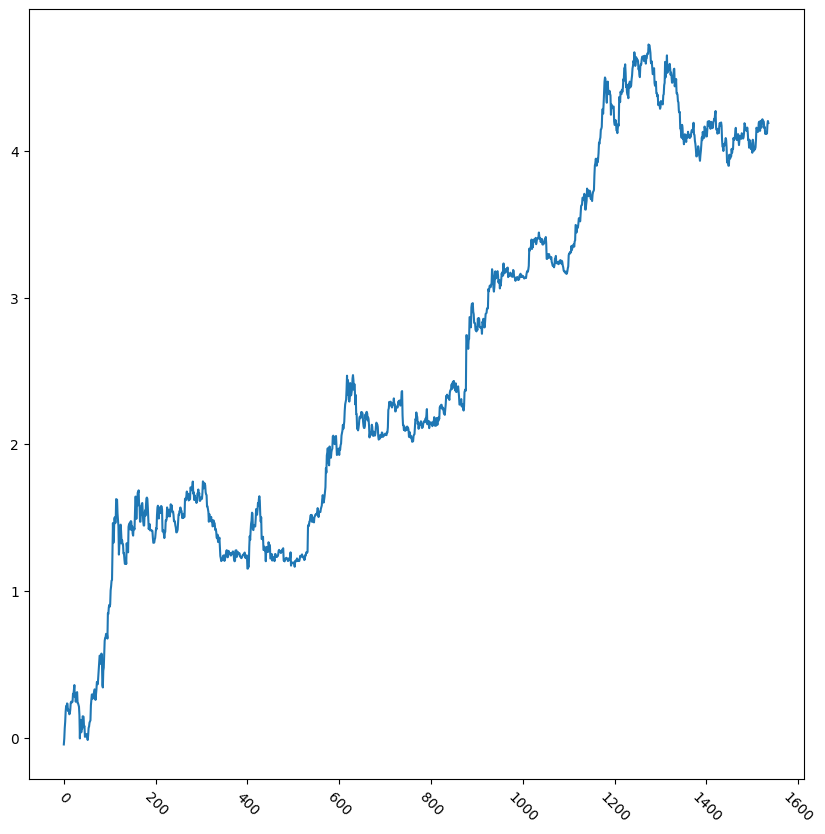

In [ ]:
# Plot the strategy returns in the test period
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.plot(np.cumsum(rewards))
plt.xticks(rotation=-45)
plt.show()